
# TF Record Pipeline for Audio Seperation

In [1]:
import os
import glob
import multiprocessing as mp
from itertools import repeat

import random
from random import normalvariate

import numpy as np 
import tensorflow as tf 

import librosa
import sounddevice as sd

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SAMPLERATE_HZ = 8000

In [3]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(list_of_floats):  # float32
    return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))

def to_tfrecord(mix, source):
    n_source = np.array(source.shape[0])
    feature = {
        'mix': _bytes_feature(mix.tobytes()),
        'source': _bytes_feature(source.tobytes()),
        'n_source': _int64_feature(n_source)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

## Fuss
* Duration: 10 seconds
* Length: 80000 at sample rate of 8000 Hz
* Cut length for model is 79872
* Domain: [-1,1]
* Training: 20000
* Val: 1000
* Eval: 1000


In [4]:
fuss_path = 'fuss'
fuss_eval = fuss_path+'/eval'
fuss_train = fuss_path+'/train'
fuss_validation = fuss_path+'/validation'

eval_source_file_paths = glob.glob(fuss_eval+"/*/")
eval_source_file_paths.sort()

eval_mix_audio_paths = glob.glob(fuss_eval+"/*.wav")
eval_mix_audio_paths.sort()

train_source_file_paths = glob.glob(fuss_train+"/*/")
train_source_file_paths.sort()

train_mix_audio_paths = glob.glob(fuss_train+"/*.wav")
train_mix_audio_paths.sort()

validation_source_file_paths = glob.glob(fuss_validation+"/*/")
validation_source_file_paths.sort()

validation_mix_audio_paths = glob.glob(fuss_validation+"/*.wav")
validation_mix_audio_paths.sort()

print("Number of train sample: {}".format(len(train_mix_audio_paths)))
print("Number of val sample: {}".format(len(validation_mix_audio_paths)))
print("Number of eval sample: {}".format(len(eval_mix_audio_paths)))

Number of train sample: 20000
Number of val sample: 1000
Number of eval sample: 1000


In [ ]:
fuss_sample_data, _ = librosa.load(eval_mix_audio_paths[10], sr=SAMPLERATE_HZ)
sd.play(fuss_sample_data, SAMPLERATE_HZ)
status = sd.wait()

In [ ]:
plt.plot(range(fuss_sample_data.shape[0]),fuss_sample_data)
plt.title('Fuss Sample Data')

In [ ]:
for i,s in enumerate(train_mix_audio_paths[:20]):
    fuss_sample_data, _ = librosa.load(s, sr=SAMPLERATE_HZ)
    print("{}: max = {:.4f}, min = {:.4f}, duration = {}, length = {}".format(i,np.max(fuss_sample_data),np.min(fuss_sample_data),librosa.get_duration(fuss_sample_data,sr=SAMPLERATE_HZ),fuss_sample_data.shape[0]))

In [ ]:
def writeRecordFuss(source_file_paths,index,tf_path):
    with tf.io.TFRecordWriter(tf_path+'/'+str(index)+'.tfrecord') as out:
        for folder_path in source_file_paths:
            mix_wav_path = folder_path.split("_")[0]+".wav"
            source_file_paths = glob.glob(folder_path+'/*.wav')
            source_file_paths.sort()

            # Load mixed sample 
            mix_audio, _ = librosa.load(mix_wav_path, sr=SAMPLERATE_HZ)
            mix_audio = mix_audio[:79872]

            # Load source samples
            source_sounds = []
            for source_path in source_file_paths:
                source_audio, _ = librosa.load(source_path, sr=SAMPLERATE_HZ)
                source_sounds.append(source_audio[:79872])

            # Add dummy source samples if needed
            if len(source_sounds) != 4:
                for i in range(4-len(source_sounds)):
                    dummy_source = np.zeros((79872,),dtype='float32')
                    source_sounds.append(dummy_source)
            source = np.stack(source_sounds)

            # Encode [mix, source] pair to TFRecord format
            example = to_tfrecord(mix_audio, source)
            # Write serialized example to TFRecord file
            out.write(example.SerializeToString())

In [ ]:
# Make tf Record for val 
validation_source_file_paths_cuts = chunks(validation_source_file_paths,100)
val_index = list(range(len(validation_source_file_paths_cuts)))

with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.starmap(writeRecordFuss, zip(validation_source_file_paths_cuts,val_index,repeat(fuss_path+'/tf_val')))

In [ ]:
# Make tf Record for eval
eval_source_file_paths_cuts = chunks(eval_source_file_paths,100)
eval_index = list(range(len(eval_source_file_paths_cuts)))

with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.starmap(writeRecordFuss, zip(eval_source_file_paths_cuts,eval_index,repeat(fuss_path+'/tf_eval')))

In [ ]:
# Make tf Record for train
train_source_file_paths_cuts = chunks(train_source_file_paths,100)
train_index = list(range(len(train_source_file_paths_cuts)))

with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.starmap(writeRecordFuss, zip(train_source_file_paths_cuts,train_index,repeat(fuss_path+'/tf_train')))

## Read tfRecord of Fuss

In [ ]:
def tf_shuffle_axis(value, rank, axis=0, seed=None, name=None):
    perm = list(range(rank))
    perm[axis], perm[0] = perm[0], perm[axis]
    value = tf.random.shuffle(tf.transpose(value, perm=perm))
    value = tf.transpose(value, perm=perm)
    return value

##############################

def parse_tfrecord(example,batch_size):
    feature_description = {
        'mix': tf.io.FixedLenFeature([], tf.string),
        'source': tf.io.FixedLenFeature([], tf.string),
        'n_source': tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_example(example, feature_description)
    
    mix = tf.io.decode_raw(
        example['mix'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    
    source = tf.io.decode_raw(
        example['source'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    
    source = tf.reshape(source,(batch_size,4,-1)) 
    source = tf_shuffle_axis(source,3,axis=1)
    
    return (mix, source)

##############################

def getDatasetFuss(record_files,AUTO,batch_size=2):
    """ Loads tfRecord files
    Parameters
    ----------
    record_files : str or list of str
        paths of tfRecord files
    Returns
    -------
    tf.data.Dataset
        data loader for keras model
    """
    
    # Disregard data order in favor of reading speed
    files_ds = tf.data.Dataset.list_files(record_files)
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    files_ds = files_ds.with_options(ignore_order)

    dataset = tf.data.TFRecordDataset(files_ds, num_parallel_reads=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x: parse_tfrecord(x,batch_size), num_parallel_calls=AUTO)
                                      
    return dataset.prefetch(buffer_size=AUTO)

In [ ]:
sample_dataset = getDatasetFuss(glob.glob(fuss_path+'/tf_eval/*.tfrecord'),AUTOTUNE,batch_size=2)
print(sample_dataset)

In [ ]:
for sample in sample_dataset.take(1):
    mix, source = sample
    print(mix.shape)
    print(source.shape)

In [ ]:
sd.play(mix[0,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(mix.shape[1]),mix[0,:])
plt.title('Mix Sample Data')

In [ ]:
sd.play(source[0,0,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,0,:])
plt.title('Source 1 Sample Data')

In [ ]:
sd.play(source[0,1,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,1,:])
plt.title('Source 2 Sample Data')

In [ ]:
sd.play(source[0,2,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,2,:])
plt.title('Source 3 Sample Data')

In [ ]:
sd.play(source[0,3,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,3,:])
plt.title('Source 4 Sample Data')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Summed Source | Orginal Mixed')
ax1.plot(range(source.shape[2]),np.sum(source[0,:,:],axis=0))
ax2.plot(range(mix.shape[1]),mix[0,:])

## Make tfRecord Sudo Dynamic Mixing dataset for Fuss

In [10]:
fuss_path = 'fuss'
fuss_train = fuss_path+'/train'

train_source_file_paths = glob.glob(fuss_train+"/*/")

all_files = []
for dir_path in train_source_file_paths:
    for file in os.listdir(dir_path):
        all_files.append(dir_path+file)

background_paths = [k for k in all_files if 'background' in k]
foreground_paths = [k for k in all_files if 'foreground' in k]

background_paths.sort()
foreground_paths.sort()

In [11]:
print('Number of background samples: {}'.format(len(background_paths)))
for path in background_paths[:10]:
    print(path)

Number of background samples: 20000
fuss/train/example00000_sources/background0_sound.wav
fuss/train/example00001_sources/background0_sound.wav
fuss/train/example00002_sources/background0_sound.wav
fuss/train/example00003_sources/background0_sound.wav
fuss/train/example00004_sources/background0_sound.wav
fuss/train/example00005_sources/background0_sound.wav
fuss/train/example00006_sources/background0_sound.wav
fuss/train/example00007_sources/background0_sound.wav
fuss/train/example00008_sources/background0_sound.wav
fuss/train/example00009_sources/background0_sound.wav


In [12]:
print('Number of foreground samples: {}'.format(len(foreground_paths)))
for path in foreground_paths[:10]:
    print(path)

Number of foreground samples: 30067
fuss/train/example00000_sources/foreground0_sound.wav
fuss/train/example00000_sources/foreground1_sound.wav
fuss/train/example00000_sources/foreground2_sound.wav
fuss/train/example00001_sources/foreground0_sound.wav
fuss/train/example00001_sources/foreground1_sound.wav
fuss/train/example00002_sources/foreground0_sound.wav
fuss/train/example00003_sources/foreground0_sound.wav
fuss/train/example00003_sources/foreground1_sound.wav
fuss/train/example00003_sources/foreground2_sound.wav
fuss/train/example00004_sources/foreground0_sound.wav


In [15]:
def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)
    return np.pad(array, pad_width=npad, mode="constant", constant_values=0)

def to_tfrecord_dm(background_samples,foreground_samples):
    n_source = int(np.array(foreground_samples.shape[0]))
    feature = {
        'background': _bytes_feature(background_samples.tobytes()),
        'foreground': _bytes_feature(foreground_samples.tobytes()),
        'n_source': _int64_feature(n_source)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def writeRecordFussSudoEfficientDM(background_paths, foreground_paths, index, tf_path):
    with tf.io.TFRecordWriter(tf_path+'/'+str(index)+'.tfrecord') as out:
        for i, background_path in enumerate(background_paths):
            # Load data and apply time speed augment between .95 and 1.05
            foreground_sample_paths = random.sample(foreground_paths, 3) 
            
            background_sample, _ = librosa.load(background_path, sr=8000)
            background_sample = librosa.effects.time_stretch(background_sample,random.uniform(.95,1.05))
            if len(background_sample) < 79872: #pad
                background_sample = pad_along_axis(background_sample,79872)
            elif len(background_sample) > 79872: # cut 
                background_sample = background_sample[:79872]

            foreground_sample_1, _ = librosa.load(foreground_sample_paths[0], sr=8000)
            foreground_sample_1 = librosa.effects.time_stretch(foreground_sample_1,random.uniform(.95,1.05))
            if len(foreground_sample_1) < 79872: #pad
                foreground_sample_1 = pad_along_axis(foreground_sample_1,79872)
            elif len(foreground_sample_1) > 79872: # cut 
                foreground_sample_1 = foreground_sample_1[:79872]
            
            foreground_sample_2, _ = librosa.load(foreground_sample_paths[1], sr=8000)
            foreground_sample_2 = librosa.effects.time_stretch(foreground_sample_2,random.uniform(.95,1.05))
            if len(foreground_sample_2) < 79872: #pad
                foreground_sample_2 = pad_along_axis(foreground_sample_2,79872)
            elif len(foreground_sample_2) > 79872: # cut 
                foreground_sample_2 = foreground_sample_2[:79872]

            foreground_sample_3, _ = librosa.load(foreground_sample_paths[2], sr=8000)
            foreground_sample_3 = librosa.effects.time_stretch(foreground_sample_3,random.uniform(.95,1.05))
            if len(foreground_sample_3) < 79872: #pad
                foreground_sample_3 = pad_along_axis(foreground_sample_3,79872)
            elif len(foreground_sample_3) > 79872: # cut 
                foreground_sample_3 = foreground_sample_3[:79872]
            
            # Shape data 
            foreground_samples = np.stack([foreground_sample_1,foreground_sample_2,foreground_sample_3])
            
            # Encode [source] to TFRecord format
            example = to_tfrecord_dm(background_sample,foreground_samples)
            # Write serialized example to TFRecord file
            out.write(example.SerializeToString())

In [16]:
n_samples = 1000
train_dm_index = list(range(n_samples//100))
background_path_batches, foreground_path_batches = [], []
for i in range(n_samples//100):
    background_path_batches.append(random.sample(background_paths,100))
    foreground_path_batches.append(random.sample(foreground_paths,100))

# Make tf Record for train sudo efficient DM
with mp.Pool(processes=mp.cpu_count()) as pool:
    pool.starmap(writeRecordFussSudoEfficientDM, zip(background_path_batches,\
                foreground_path_batches,train_dm_index,repeat(fuss_path+'/tf_train_dm')))

## Read tfRecord of Fuss for train on DM

In [42]:
def tf_shuffle_axis(value, rank, axis=0, seed=None, name=None):
    perm = list(range(rank))
    perm[axis], perm[0] = perm[0], perm[axis]
    value = tf.random.shuffle(tf.transpose(value, perm=perm))
    value = tf.transpose(value, perm=perm)
    return value

def parse_tfrecord_fuss_dm(example,batch_size):
    feature_description = {
        'background': tf.io.FixedLenFeature([], tf.string),
        'foreground': tf.io.FixedLenFeature([], tf.string),
        'n_source': tf.io.FixedLenFeature([], tf.int64),
    }

    example = tf.io.parse_example(example, feature_description)
    
    background = tf.io.decode_raw(
        example['background'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    
    foreground = tf.io.decode_raw(
        example['foreground'], out_type='float32', little_endian=True, fixed_length=None, name=None
    )
    
    # Appply Dynamix mixing 
    foreground = tf.reshape(foreground,(batch_size*3,-1)) 
    foreground_mask = tf.transpose(tf.random.categorical(tf.math.log([[0.5, 0.5]]),batch_size*3))
    foreground_mask = tf.cast(foreground_mask,dtype='float32')
    foreground *= foreground_mask
    foreground = tf.reshape(foreground,(batch_size,3,-1))
    
    background = tf.reshape(background,(batch_size,1,-1))
    
    # Shuffle foreground and background on each sample within batch 
    source = tf.concat([foreground,background], axis=1)
    source = tf_shuffle_axis(source,3,axis=1)
    
    # Apply gain 
    gain = tf.random.uniform((batch_size,4,1),-1,1)
    source *= gain
    
    # Form mix and scale
    mixture = tf.math.reduce_sum(source,axis=1)
    max_amp = tf.math.reduce_max(mixture)
    mix_scaling = 1/max_amp*.9
    source = mix_scaling*source
    mixture = mix_scaling*mixture
    return tf.clip_by_value(mixture,-1,1), tf.clip_by_value(source,-1,1)
    
def getDatasetFussDM(record_files,AUTO,batch_size=2):
    """ Loads tfRecord files
    Parameters
    ----------
    record_files : str or list of str
        paths of tfRecord files
    Returns
    -------
    tf.data.Dataset
        data loader for keras model
    """
    
    # Disregard data order in favor of reading speed
    files_ds = tf.data.Dataset.list_files(record_files)
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    files_ds = files_ds.with_options(ignore_order)

    dataset = tf.data.TFRecordDataset(files_ds, num_parallel_reads=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda x: parse_tfrecord_fuss_dm(x,batch_size), num_parallel_calls=AUTO)
                                      
    return dataset.prefetch(buffer_size=AUTO)

In [43]:
sample_dataset = getDatasetFussDM(glob.glob(fuss_path+'/tf_train_dm/*.tfrecord'),AUTOTUNE,batch_size=2)
print(sample_dataset)

<PrefetchDataset shapes: ((2, None), (2, 4, None)), types: (tf.float32, tf.float32)>


In [51]:
for sample in sample_dataset.take(1):
    mix, source = sample
    print(mix.shape)
    print(source.shape)

(2, 79872)
(2, 4, 79872)


Text(0.5, 1.0, 'Mix Sample Data')

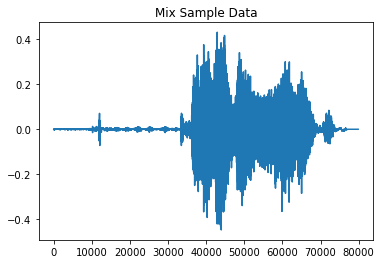

In [52]:
sd.play(mix[0,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(mix.shape[1]),mix[0,:])
plt.title('Mix Sample Data')

Text(0.5, 1.0, 'Source 1 Sample Data')

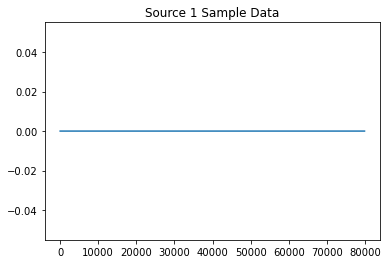

In [53]:
sd.play(source[0,0,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,0,:])
plt.title('Source 1 Sample Data')

Text(0.5, 1.0, 'Source 2 Sample Data')

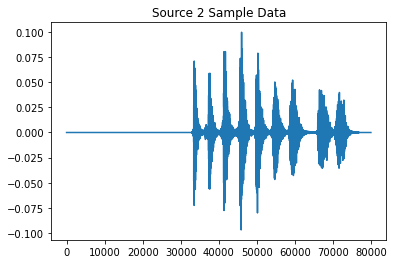

In [54]:
sd.play(source[0,1,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,1,:])
plt.title('Source 2 Sample Data')

Text(0.5, 1.0, 'Source 3 Sample Data')

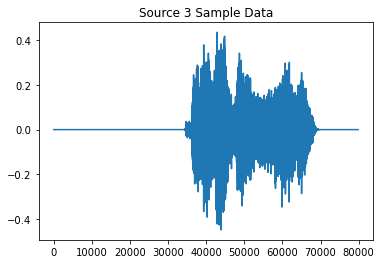

In [55]:
sd.play(source[0,2,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,2,:])
plt.title('Source 3 Sample Data')

Text(0.5, 1.0, 'Source 4 Sample Data')

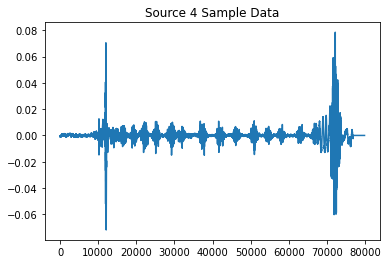

In [56]:
sd.play(source[0,3,:], SAMPLERATE_HZ)
status = sd.wait()

plt.plot(range(source.shape[2]),source[0,3,:])
plt.title('Source 4 Sample Data')

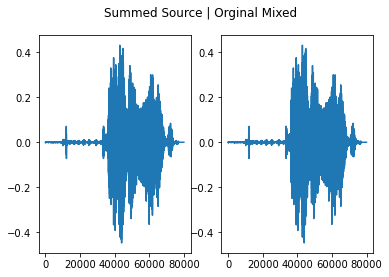

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Summed Source | Orginal Mixed')
ax1.plot(range(source.shape[2]),np.sum(source[0,:,:],axis=0))
ax2.plot(range(mix.shape[1]),mix[0,:])